In [1]:
%matplotlib notebook
%matplotlib inline
import pandas as pd
import numpy as np
import re as re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import random, sys, os
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

In [2]:
df = pd.read_csv('dataset/news.csv')
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
id          3000 non-null object
headline    3000 non-null object
text        3000 non-null object
dtypes: object(3)
memory usage: 70.4+ KB
None


,id,headline,text
0,uid-1,Market Advances 5.12 More,NEW YORK (AP) - A prime rate reduction by New ...
1,uid-2,District Boosts Request For Anti-Terrorism Aid...,Mayor Anthony A. Williams petitioned the White...
2,uid-3,"Election? Here's How You Do It, Mate.",From our downunder perspective here in Austral...
3,uid-4,The Biggest Boom Ever,We are about to rewrite history. Unless a rece...
4,uid-5,Economic Aide Sees Uptrend,"Sedate and scholarly Dr. Arthur Burns, the ex-..."


In [3]:
print('ï¿½ï¿½ï¿½')
print('ï¿½Ûªs')
df['cluster'] = 0
# df['text_len'] = df['text'].apply(lambda x: len(x))
# df['text_array'] = df['text'].apply(lambda x: x.split(' '))
# len(df['text_array'])
# df['text_array_1'] = df['text_array'].apply(lambda x: x[0])
# df.loc[df['text_array_1'] == 'Author:','cluster'] = 1
# df[df['text_array_1'] == 'Author:']
df.head(3)    

ï¿½ï¿½ï¿½
ï¿½Ûªs


,id,headline,text,cluster
0,uid-1,Market Advances 5.12 More,NEW YORK (AP) - A prime rate reduction by New ...,0
1,uid-2,District Boosts Request For Anti-Terrorism Aid...,Mayor Anthony A. Williams petitioned the White...,0
2,uid-3,"Election? Here's How You Do It, Mate.",From our downunder perspective here in Austral...,0


In [150]:
# LDA TOPIC MODELLING
import pickle
import gensim
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizor to find three letter tokens, remove stop_words, 
# remove tokens that don't appear in at least 20 documents,
# remove tokens that appear in more than 20% of the documents
# vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', 
#                        token_pattern='(?u)\\b\\w\\w\\w+\\b')
# Fit and transform
# X = vect.fit_transform(df['text'])


from sklearn.feature_extraction.text import TfidfVectorizer
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.2,
    max_features=200000,
    min_df=20,
    stop_words='english',
    use_idf=True,
    tokenizer=tokenize_and_stem,
#     ngram_range=(1, 3)
    )

# %time tfidf_matrix = tfidf_vectorizer.fit_transform(df['text']) #fit the vectorizer to synopses
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['text']) #fit the vectorizer to synopses
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()







# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(tfidf_matrix, documents_columns=False)

# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

CPU times: user 8.65 s, sys: 16 ms, total: 8.66 s
Wall time: 8.66 s
(3000, 2420)


In [159]:
topic = 2
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,passes=25,random_state=34,num_topics=topic,id2word=id_map)

In [160]:
def lda_topics():
    # Your Code Here
    ans = [(i,ldamodel.print_topic(topicno=i)) for i in range(topic) ]
    return ans
lda_topics()

[(0,
  '0.004*"tax" + 0.004*"state" + 0.004*"bank" + 0.004*"president" + 0.004*"government" + 0.003*"budget" + 0.003*"say" + 0.003*"house" + 0.003*"loan" + 0.003*"money"'),
 (1,
  '0.006*"percent" + 0.005*"bond" + 0.005*"share" + 0.005*"investor" + 0.005*"index" + 0.005*"dollar" + 0.005*"dow" + 0.004*"rose" + 0.004*"trading" + 0.004*"sale"')]

In [161]:
a = [df['text'][5]]
def topic_distribution(row):    
    X = tfidf_vectorizer.transform(row)
    corp = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    return list(ldamodel.get_document_topics(corp))[0]
topic_distribution(a)

[(0, 0.8576048), (1, 0.14239521)]

In [162]:
r = np.zeros((3000,topic))
for i,row in enumerate(df['text']):
    topic_proba = topic_distribution([row])
    for topic in topic_proba:
        index = int(topic[0])
        val = float(topic[1])
        r[i][index] = val

In [163]:
np.savetxt('submission_lda1.txt',X=r)

In [164]:
def check(row):
    return np.argmax(row)
du = pd.read_csv('submission_lda1.txt',sep=' ',header=None)
du['cluster'] = du.apply(check,axis=1)
# du.head()
Submission = pd.DataFrame({ 'id':df['id'] ,
                            'cluster': du['cluster'] })
Submission.to_csv("submission_lda1.csv", index=False)

In [11]:
# KMEANS TOPIC MODELLING

In [4]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
porter = PorterStemmer()
lancaster=LancasterStemmer()

print(porter.stem(df['text'][0]))
print("\n")
print(lancaster.stem(df['text'][0]))
print("\n")

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
stemSentence(df['text'][0])

new york (ap) - a prime rate reduction by new york's first national city bank helped the stock market close out the busiest week in its history with a modest advance friday.</br></br>the dow jones average of 30 industrial stocks gained 5.12 to 929.63, finishing the week withanetrise of 18.50 points.</br></br>big board volume, at 25.94 million shares, fell a good deal short of matching thursday's all-time high of 38.45 million.</br></br>but the day�۪s figure was more than enough to push the total for the week to a record 159.69 million shares. the previous peak had been 145.68 million in the last week of january 1975.</br></br>the dow has advanced in all but two of the first 11 sessions of the new year. as of friday�۪s close it had gained 77.22 points since new year�۪s.


new york (ap) - a prime rate reduction by new york's first national city bank helped the stock market close out the busiest week in its history with a modest advance friday.</br></br>the dow jones average of 30 industr

"new york ( AP ) - A prime rate reduct by new york 's first nation citi bank help the stock market close out the busiest week in it histori with a modest advanc friday. < /br > < /br > the dow jone averag of 30 industri stock gain 5.12 to 929.63 , finish the week withanetris of 18.50 points. < /br > < /br > big board volum , at 25.94 million share , fell a good deal short of match thursday 's all-tim high of 38.45 million. < /br > < /br > but the day�۪ figur wa more than enough to push the total for the week to a record 159.69 million share . the previou peak had been 145.68 million in the last week of januari 1975. < /br > < /br > the dow ha advanc in all but two of the first 11 session of the new year . As of friday�۪ close it had gain 77.22 point sinc new year�۪ . "

In [102]:
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    punctuations="?:!.,;'�۪"
    for token in tokens:
        if token in punctuations:
            tokens.remove(token)
        if re.search('[a-zA-Z0-9]', token):
            filtered_tokens.append(token)
#     stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [wordnet_lemmatizer.lemmatize(t) for t in filtered_tokens]
    st = ' '.join(stems)
# #     st = ' '.join(filtered_tokens)
    t = st.replace("/br","")
    u = t.replace("�","")
    u = u.split(' ')
    return u
tokenize_and_stem(df['text'][0])

['NEW',
 'YORK',
 'AP',
 'A',
 'prime',
 'rate',
 'reduction',
 'by',
 'New',
 'York',
 "'s",
 'First',
 'National',
 'City',
 'Bank',
 'helped',
 'the',
 'stock',
 'market',
 'close',
 'out',
 'the',
 'busiest',
 'week',
 'in',
 'it',
 'history',
 'with',
 'a',
 'modest',
 'advance',
 'Friday.',
 '',
 '',
 'The',
 'Dow',
 'Jones',
 'average',
 'of',
 '30',
 'industrial',
 'stock',
 'gained',
 '5.12',
 'to',
 '929.63',
 'the',
 'week',
 'withanetrise',
 'of',
 '18.50',
 'points.',
 '',
 '',
 'Big',
 'Board',
 'volume',
 '25.94',
 'million',
 'share',
 'a',
 'good',
 'deal',
 'short',
 'of',
 'matching',
 'Thursday',
 "'s",
 'all-time',
 'high',
 'of',
 '38.45',
 'million.',
 '',
 '',
 'But',
 'the',
 'day۪s',
 'figure',
 'wa',
 'more',
 'than',
 'enough',
 'to',
 'push',
 'the',
 'total',
 'for',
 'the',
 'week',
 'to',
 'a',
 'record',
 '159.69',
 'million',
 'share',
 'previous',
 'peak',
 'had',
 'been',
 '145.68',
 'million',
 'in',
 'the',
 'last',
 'week',
 'of',
 'January',
 '19

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8,
#     max_features=200000,
    min_df=0.01,
#     stop_words='english',
    use_idf=True,
    tokenizer=tokenize_and_stem,
#     ngram_range=(1, 3)
    )

# %time tfidf_matrix = tfidf_vectorizer.fit_transform(df['text']) #fit the vectorizer to synopses
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['text']) #fit the vectorizer to synopses
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

CPU times: user 8.46 s, sys: 3.79 ms, total: 8.47 s
Wall time: 8.46 s
(3000, 1947)


In [128]:
type(df['text'])
len(tfidf_vectorizer.get_feature_names())

1947

In [129]:
terms

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '1',
 '1,000',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1/2',
 '10',
 '10-year',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1970s',
 '1980',
 '1980s',
 '1982',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1990s',
 '1992',
 '1993',
 '1994',
 '1996',
 '1998',
 '1999',
 '2',
 '2.2',
 '2.3',
 '2.5',
 '2.6',
 '2.7',
 '2.8',
 '20',
 '200',
 '2000',
 '2001',
 '2004',
 '2008',
 '2009',
 '2010',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '3.3',
 '3.5',
 '30',
 '30-year',
 '300',
 '31',
 '35',
 '37',
 '4',
 '40',
 '400',
 '5',
 '50',
 '500',
 '500-stock',
 '55',
 '6',
 '60',
 '600',
 '7',
 '70',
 '75',
 '8',
 '80',
 '9',
 '90',
 'a.',
 'ability',
 'able',
 'about',
 'above',
 'abroad',
 'accelerating',
 'accept',
 'access',
 'according',
 'account',
 'accounting',
 'accused',
 'acquisition',
 'a

Using matplotlib backend: nbAgg
CPU times: user 942 ms, sys: 3.99 ms, total: 946 ms
Wall time: 487 ms


<IPython.core.display.Javascript object>


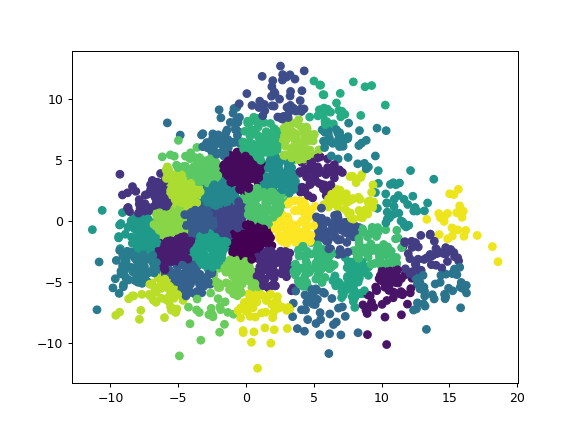

In [7]:
%matplotlib
from sklearn.decomposition import PCA,SparsePCA,TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
# ])        
# X = pipeline.fit_transform(newsgroups_train.data).todense()

x = tfidf_matrix.toarray()
x_normalized = StandardScaler(with_mean=False).fit(x).transform(x)  
pca = PCA(n_components=2).fit(x_normalized)
data2D = pca.transform(x_normalized)
num_clusters = 40

km = KMeans(n_clusters=num_clusters,n_jobs=-1,algorithm="auto",init='k-means++',max_iter=120,n_init=2)

%time km.fit(data2D)

clusters = km.labels_.tolist()

plt.scatter(data2D[:,0], data2D[:,1], c=km.labels_)
plt.show()

In [97]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
tfidf_matrix_dense = tfidf_matrix.todense()
# pca = PCA(n_components=5).fit(tfidf_matrix_dense)
# data = pca.transform(tfidf_matrix_dense)
num_clusters = 40

km = KMeans(n_clusters=num_clusters,n_jobs=-1,algorithm="auto",init='k-means++',max_iter=120,n_init=2)
%time km.fit(tfidf_matrix)
# transfromed_data = km.fit_transform(data)
clusters = km.labels_.tolist()
clust = pd.Series(clusters)
# tt = tfidf_matrix.toarray()
# tt = x_normalized
from sklearn.metrics import silhouette_score
ans = silhouette_score(tfidf_matrix,clusters,metric='euclidean')
ans

CPU times: user 30.1 s, sys: 470 µs, total: 30.1 s
Wall time: 11.9 s


0.006452828669523638

In [49]:
from sklearn.cluster import DBSCAN

num_clusters = 20

dbscan = DBSCAN(n_jobs=-1)

%time dbscan.fit(tfidf_matrix)

clusters = dbscan.labels_.tolist()
clust = pd.Series(clusters)
tt = tfidf_matrix.toarray()

CPU times: user 686 ms, sys: 58.1 ms, total: 744 ms
Wall time: 1.59 s


In [111]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

tfidf_matrix_dense = tfidf_matrix.todense()
pca = PCA(n_components=2).fit(tfidf_matrix_dense)
data = pca.transform(tfidf_matrix_dense)
# data = tfidf_matrix_dense
num_clusters = 1000

aggCluster = AgglomerativeClustering(n_clusters=num_clusters)

%time aggCluster.fit(data)

clusters = aggCluster.labels_.tolist()
clust = pd.Series(clusters)
tt = tfidf_matrix.toarray()

from sklearn.metrics import silhouette_score

ans = silhouette_score(data,clusters,metric='euclidean')
ans

CPU times: user 721 ms, sys: 4.37 ms, total: 726 ms
Wall time: 192 ms


0.3816600352420363

In [147]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

tfidf_matrix_dense = tfidf_matrix.todense()
pca = PCA(n_components=2).fit(tfidf_matrix_dense)
data = pca.transform(tfidf_matrix_dense)
# data = tfidf_matrix
num_clusters = 1000
km = MiniBatchKMeans(n_clusters=num_clusters)
%time km.fit(data)
clusters = km.labels_.tolist()
clust = pd.Series(clusters)

ans = silhouette_score(data,clusters)
ans

CPU times: user 8.47 s, sys: 0 ns, total: 8.47 s
Wall time: 2.12 s


0.3359305579480272

In [41]:
data = data.reshape(-1,1)
data.shape

(3000, 1)

In [40]:
np.savetxt('submission_kmeans1.txt',X=data)
df['cluster'] = clust
Submission = pd.DataFrame({ 'id':df['id'] ,
                            'cluster': df['cluster'] })
Submission.to_csv("submission_kmeans1.csv", index=False)

In [47]:
df.head()

# print("Top terms per cluster:")
# order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()
# for i in range(true_k):
#     print "Cluster %d:" % i,
#     for ind in order_centroids[i, :10]:
#         print ' %s' % terms[ind],
#     print

,id,headline,text,cluster
0,uid-1,Market Advances 5.12 More,NEW YORK (AP) - A prime rate reduction by New ...,9
1,uid-2,District Boosts Request For Anti-Terrorism Aid...,Mayor Anthony A. Williams petitioned the White...,7
2,uid-3,"Election? Here's How You Do It, Mate.",From our downunder perspective here in Austral...,16
3,uid-4,The Biggest Boom Ever,We are about to rewrite history. Unless a rece...,6
4,uid-5,Economic Aide Sees Uptrend,"Sedate and scholarly Dr. Arthur Burns, the ex-...",2
